# Recommender with splitted user 

In [1]:
import pandas as pd
import numpy as np 
import scipy.sparse as sps
import os
import sys
import matplotlib.pyplot as plt
sys.path.append('..')

dataset = pd.read_csv('data_train.csv')
dataset

,row,col,data
0,0,10080,1.0
1,0,19467,1.0
2,1,2665,1.0
3,1,7494,1.0
4,1,17068,1.0
...,...,...,...
113263,7945,2476,1.0
113264,7945,12319,1.0
113265,7945,21384,1.0
113266,7946,8699,1.0


In [2]:
users = dataset.row
items = dataset.col
data = dataset.data
URM_all = sps.coo_matrix((data, (users, items)))
URM_all = URM_all.tocsr() #fast row access -> fast access to users 
URM_all.shape

(7947, 25975)

In [3]:
items_per_user = np.ediff1d(URM_all.indptr) #tells in which position each of the rows begin
users_per_item = np.ediff1d(sps.csc_matrix(URM_all).indptr)
URM_all = sps.csr_matrix(URM_all)

In [4]:
items_per_user = np.sort(items_per_user) #sorting based on the single value. Losing reference to the user. 
users_per_item = np.sort(users_per_item)

In [5]:
ICM_df = pd.read_csv('data_ICM_title_abstract.csv')
ICM_df

,row,col,data
0,0,1185,1.015524
1,0,2507,0.459024
2,0,3534,0.227742
3,0,8766,0.501549
4,0,10862,0.297011
...,...,...,...
490686,25974,12554,0.963016
490687,25974,13003,0.104613
490688,25974,16236,0.118760
490689,25974,18797,0.363301


In [6]:
items = ICM_df.row
features = ICM_df.col
data = ICM_df.data
ICM_all = sps.coo_matrix((data, (items, features)))
ICM_all = ICM_all.tocsr() #fast row access -> fast access to users 
ICM_all.shape

(25975, 20000)

In [7]:
ICM_all = sps.csr_matrix(ICM_all)
features_per_item = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csc_matrix(ICM_all)
items_per_feature = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csr_matrix(ICM_all)

In [8]:
features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)

# Data pre-processing

In [9]:
from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from GraphBased.P3alphaRecommender import P3alphaRecommender
from GraphBased.RP3betaRecommender import RP3betaRecommender
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from KNN.UserKNNCFRecommender import UserKNNCFRecommender
from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Base.NonPersonalizedRecommender import TopPop
from MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from SLIM_BPR.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from GraphBased.P3alphaRecommender import P3alphaRecommender
from GraphBased.RP3betaRecommender import RP3betaRecommender
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from KNN.UserKNNCFRecommender import UserKNNCFRecommender
from KNN.ItemKNNScoresHybridMultipleRecommender import ItemKNNScoresHybridMultipleRecommender
from GraphBased.RP3betaRecommender_user import RP3betaRecommender_user
from MatrixFactorization.PureSVDRecommender import PureSVDRecommender


MAP_p3aplha_rp3beta_per_group = [0, 0, 0, 0, 0]
MAP_user_cf_cold_per_group = [0, 0, 0, 0, 0]
MAP_item_cf_cold_per_group = [0, 0, 0, 0, 0]
MAP_item_cbf_per_group = [0, 0, 0, 0, 0]
MAP_top_pop_per_group = [0, 0, 0, 0, 0]
MAP_pure_svd_per_group = [0, 0, 0, 0, 0]
MAP_slim_bpr_per_group = [0, 0, 0, 0, 0]
MAP_top_model_per_group = [0, 0, 0, 0, 0]
cutoff = 10

In [10]:
for index in range(0, 15):
    URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)

    recommender_alpha = P3alphaRecommender(URM_train)
    recommender_alpha.fit(topK=170, alpha = 0.45, implicit = True)

    recommender_beta_ICM = RP3betaRecommender(ICM_all.T)
    recommender_beta_ICM.fit(topK=70, alpha=0.2, beta=0.5, implicit=False)
    recommender_beta_ICM.URM_train = URM_train

    hybridrecommender = ItemKNNSimilarityHybridRecommender(URM_train, recommender_alpha.W_sparse, recommender_beta_ICM.W_sparse)
    hybridrecommender.fit(topK=200, alpha = 0.1)

    '''#user knn
    recommender_cold = UserKNNCFRecommender(URM_train)
    recommender_cold.fit(shrink=100, topK=150, feature_weighting = "TF-IDF")

    recommender_item_cf = ItemKNNCFRecommender(URM_train)
    recommender_item_cf.fit(shrink=600, topK=550, feature_weighting = "TF-IDF")

    recommeder_KNNItemCBF = ItemKNNCBFRecommender(URM_train, ICM_all)
    recommeder_KNNItemCBF.fit(topK=100, shrink=400, feature_weighting = 'TF-IDF')

    recommender_top_popular = TopPop(URM_train)
    recommender_top_popular.fit()

    recommender_pure_svd = PureSVDRecommender(URM_train)
    recommender_pure_svd.fit(num_factors = 845)

    recommender_slim_bpr = SLIM_BPR_Cython(URM_train, recompile_cython=False)
    recommender_slim_bpr.fit(epochs=200, batch_size=1000, sgd_mode='adagrad', learning_rate=0.001, positive_threshold_BPR=1, topK=400)'''

    recommender_userKNN_top_model = UserKNNCFRecommender(URM_train)
    recommender_userKNN_top_model.fit(topK= 75, shrink = 200)

    recommender_SVD_top_model = PureSVDRecommender(URM_train)
    recommender_SVD_top_model.fit(num_factors = 1200)

    recommender_alpha_top_model = P3alphaRecommender(URM_train)
    recommender_alpha_top_model.fit(topK=350, alpha = 0.45, implicit = True)

    recommender_beta_ICM_top_model = RP3betaRecommender(ICM_all.T)
    recommender_beta_ICM_top_model.fit(topK=70, alpha=0.35, beta=0.4, implicit=False)
    recommender_beta_ICM_top_model.URM_train = URM_train

    hybridrecommender_p3_rp3_top_model = ItemKNNSimilarityHybridRecommender(URM_train, recommender_alpha_top_model.W_sparse, recommender_beta_ICM_top_model.W_sparse)
    hybridrecommender_p3_rp3_top_model.fit(topK=450, alpha = 0.1)

    hybridrecommender_top_model = ItemKNNScoresHybridMultipleRecommender(URM_train, hybridrecommender_p3_rp3_top_model, recommender_userKNN_top_model, recommender_SVD_top_model)
    hybridrecommender_top_model.fit(alpha = 0.7, beta=0.25)

    grouped_users = dataset.groupby(['row']).count()
    sorted_users = grouped_users.sort_values(by=['col'], ascending=True)
    sorted_users = sorted_users.index.to_numpy()

    block_size = int(len(sorted_users)*0.20)

    for group_id in range(0, 5):
        
        start_pos = group_id*block_size
        end_pos = min((group_id+1)*block_size, len(sorted_users))
        
        users_in_group = sorted_users[start_pos:end_pos]
        
        users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert = True)
        users_not_in_group = sorted_users[users_not_in_group_flag]
        
        evaluator_p3_rp3 = EvaluatorHoldout(URM_validation, cutoff_list=[cutoff], ignore_users = users_not_in_group)
        
        results, _ = evaluator_p3_rp3.evaluateRecommender(hybridrecommender)
        MAP_p3aplha_rp3beta_per_group[group_id] += results[cutoff]["MAP"]

        '''results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_cold)
        MAP_user_cf_cold_per_group[group_id] += results[cutoff]["MAP"]

        results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_item_cf)
        MAP_item_cf_cold_per_group[group_id] += results[cutoff]["MAP"]

        results, _ = evaluator_p3_rp3.evaluateRecommender(recommeder_KNNItemCBF)
        MAP_item_cbf_per_group[group_id] += results[cutoff]["MAP"]

        results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_top_popular)
        MAP_top_pop_per_group[group_id] += results[cutoff]["MAP"]

        results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_pure_svd)
        MAP_pure_svd_per_group[group_id] += results[cutoff]["MAP"]

        results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_slim_bpr)
        MAP_slim_bpr_per_group[group_id] += results[cutoff]["MAP"]'''

        results, _ = evaluator_p3_rp3.evaluateRecommender(hybridrecommender_top_model)
        MAP_top_model_per_group[group_id] += results[cutoff]["MAP"]

5975)
EvaluatorHoldout: Processed 481 ( 100.00% ) in 0.79 sec. Users per second: 609
EvaluatorHoldout: Ignoring 6358 Users
EvaluatorHoldout: Processed 719 ( 100.00% ) in 0.41 sec. Users per second: 1755
shape of item_weights: (719, 25975)
EvaluatorHoldout: Processed 719 ( 100.00% ) in 1.09 sec. Users per second: 662
EvaluatorHoldout: Ignoring 6358 Users
EvaluatorHoldout: Processed 964 ( 100.00% ) in 0.56 sec. Users per second: 1713
shape of item_weights: (964, 25975)
EvaluatorHoldout: Processed 964 ( 100.00% ) in 1.41 sec. Users per second: 684
EvaluatorHoldout: Ignoring 6358 Users
EvaluatorHoldout: Processed 1279 ( 100.00% ) in 0.76 sec. Users per second: 1677
shape of item_weights: (1000, 25975)
shape of item_weights: (279, 25975)
EvaluatorHoldout: Processed 1279 ( 100.00% ) in 2.09 sec. Users per second: 613
EvaluatorHoldout: Ignoring 6358 Users
EvaluatorHoldout: Processed 1555 ( 100.00% ) in 1.10 sec. Users per second: 1414
shape of item_weights: (1000, 25975)
shape of item_weights

In [11]:
for index in range(0, 5):
    MAP_p3aplha_rp3beta_per_group[index] /= 15
    '''MAP_user_cf_cold_per_group[index] /= 15
    MAP_item_cf_cold_per_group[index] /= 15
    MAP_item_cbf_per_group[index] /= 15
    MAP_top_pop_per_group[index] /= 15
    MAP_pure_svd_per_group[index] /= 15
    MAP_slim_bpr_per_group[index] /= 15'''
    MAP_top_model_per_group[index] /= 15

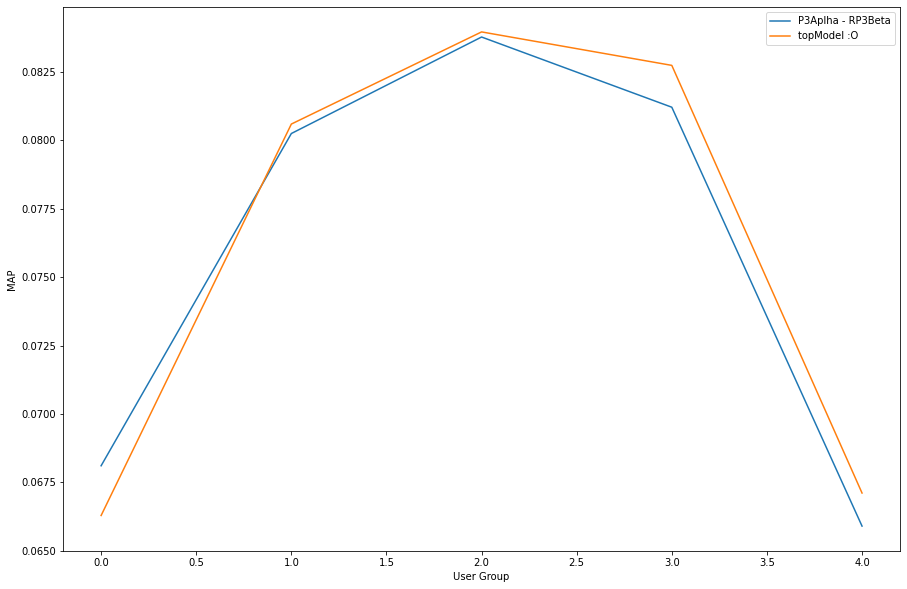

In [12]:
import matplotlib.pyplot as pyplot
%matplotlib inline  
pyplot.figure(figsize=(15,10))
pyplot.plot(MAP_p3aplha_rp3beta_per_group, label="P3Aplha - RP3Beta")
'''pyplot.plot(MAP_user_cf_cold_per_group, label="userKNNCF")
pyplot.plot(MAP_item_cf_cold_per_group, label="itemKNNCF")
pyplot.plot(MAP_item_cbf_per_group, label="itemKNNCBF")
pyplot.plot(MAP_top_pop_per_group, label="topPOP")
pyplot.plot(MAP_pure_svd_per_group, label="pureSVD")
pyplot.plot(MAP_slim_bpr_per_group, label="slimBPR")'''
pyplot.plot(MAP_top_model_per_group, label="topModel :O")

pyplot.ylabel('MAP')
pyplot.xlabel('User Group')
pyplot.legend()
pyplot.show()

# Tuning a recommender only for small class 

In [13]:
'''group_id = 1
start_pos = group_id*block_size
end_pos = min((group_id+1)*block_size, len(sorted_users))
    
users_in_group = sorted_users[start_pos:end_pos]
    
users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert = True)
users_not_in_group = sorted_users[users_not_in_group_flag]
    
evaluator_itemCBF = EvaluatorHoldout(URM_validation, cutoff_list=[cutoff], ignore_users = users_not_in_group)'''

'group_id = 1\nstart_pos = group_id*block_size\nend_pos = min((group_id+1)*block_size, len(sorted_users))\n    \nusers_in_group = sorted_users[start_pos:end_pos]\n    \nusers_not_in_group_flag = np.isin(sorted_users, users_in_group, invert = True)\nusers_not_in_group = sorted_users[users_not_in_group_flag]\n    \nevaluator_itemCBF = EvaluatorHoldout(URM_validation, cutoff_list=[cutoff], ignore_users = users_not_in_group)'

In [14]:
'''from KNN.ItemKNNScoresHybridNRecommender import ItemKNNScoresHybridNRecommender
from MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_AsySVD_Cython


recommeder_KNNItemCBF = ItemKNNCBFRecommender(URM_train, ICM_all)
recommeder_KNNItemCBF.fit(topK=150, shrink=550, feature_weighting = 'TF-IDF', similarity='cosine')
recommender_pure_svd = PureSVDRecommender(URM_train)
recommender_pure_svd.fit(num_factors = 300)

#recommender_asy_svd = MatrixFactorization_AsySVD_Cython(URM_train)
#recommender_asy_svd.fit()
recommender_top_popular = TopPop(URM_train)
recommender_top_popular.fit()

recommender_list = [recommeder_KNNItemCBF, recommender_pure_svd, recommender_top_popular]
weights_list = [0.2,0.5,0.3]
hybridrecommender_1 = ItemKNNScoresHybridNRecommender(URM_train, recommender_list, number_of_recommenders = 3)
hybridrecommender_1.fit(weight_array = weights_list)'''


"from KNN.ItemKNNScoresHybridNRecommender import ItemKNNScoresHybridNRecommender\nfrom MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_AsySVD_Cython\n\n\nrecommeder_KNNItemCBF = ItemKNNCBFRecommender(URM_train, ICM_all)\nrecommeder_KNNItemCBF.fit(topK=150, shrink=550, feature_weighting = 'TF-IDF', similarity='cosine')\nrecommender_pure_svd = PureSVDRecommender(URM_train)\nrecommender_pure_svd.fit(num_factors = 300)\n\n#recommender_asy_svd = MatrixFactorization_AsySVD_Cython(URM_train)\n#recommender_asy_svd.fit()\nrecommender_top_popular = TopPop(URM_train)\nrecommender_top_popular.fit()\n\nrecommender_list = [recommeder_KNNItemCBF, recommender_pure_svd, recommender_top_popular]\nweights_list = [0.2,0.5,0.3]\nhybridrecommender_1 = ItemKNNScoresHybridNRecommender(URM_train, recommender_list, number_of_recommenders = 3)\nhybridrecommender_1.fit(weight_array = weights_list)"

In [15]:
#evaluator_itemCBF.evaluateRecommender(hybridrecommender_1)

In [16]:
# tuning p3alpha + rp3 beta on worst classes

In [17]:
'''from GraphBased.P3alphaRecommender import P3alphaRecommender
from GraphBased.RP3betaRecommender import RP3betaRecommender
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from KNN.ItemKNNScoresHybridRecommender import ItemKNNScoresHybridRecommender


recommender_alpha = P3alphaRecommender(URM_train)
recommender_alpha.fit(topK=170, alpha = 0.45, implicit = True)

recommender_beta_ICM = RP3betaRecommender(ICM_all.T)
recommender_beta_ICM.fit(topK=70, alpha=0.2, beta=0.5, implicit=False)
recommender_beta_ICM.URM_train = URM_train

hybridrecommender = ItemKNNScoresHybridRecommender(URM_train, recommender_alpha, recommender_beta_ICM)
hybridrecommender.fit(alpha = 0.1)'''

'from GraphBased.P3alphaRecommender import P3alphaRecommender\nfrom GraphBased.RP3betaRecommender import RP3betaRecommender\nfrom KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender\nfrom KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender\nfrom KNN.ItemKNNScoresHybridRecommender import ItemKNNScoresHybridRecommender\n\n\nrecommender_alpha = P3alphaRecommender(URM_train)\nrecommender_alpha.fit(topK=170, alpha = 0.45, implicit = True)\n\nrecommender_beta_ICM = RP3betaRecommender(ICM_all.T)\nrecommender_beta_ICM.fit(topK=70, alpha=0.2, beta=0.5, implicit=False)\nrecommender_beta_ICM.URM_train = URM_train\n\nhybridrecommender = ItemKNNScoresHybridRecommender(URM_train, recommender_alpha, recommender_beta_ICM)\nhybridrecommender.fit(alpha = 0.1)'

In [18]:
#evaluator_itemCBF.evaluateRecommender(hybridrecommender)